In [1]:
import pandas as pd
import sklearn
import numpy as np
df = pd.read_csv('data/haystacks_ga_clean_new_format.csv')

In [2]:
df.columns

Index(['latitude', 'longitude', 'address', 'city', 'county', 'state',
       'zipcode', 'listing_status', 'details', 'square_footage',
       'overall_crime_grade', 'ES_rating', 'caprate', 'lot_size', 'baths_half',
       'MS_rating', 'HS_rating', 'listing_special_features', 'rent', 'beds',
       'special_features', 'price', 'baths_full', 'year_built',
       'property_crime_grade', 'transaction_type'],
      dtype='object')

In [3]:
df.listing_status.value_counts()

1    10129
0      184
Name: listing_status, dtype: int64

In [4]:
df = df.loc[~df.year_built.isnull()]

In [5]:
## Mask for turning crime grades into integers
mask = {'F': 0,
       'D-': 1,
       'D': 2,
       'D+': 3,
       'C-': 4,
       'C': 5,
       'C+': 6,
       'B-': 7,
       'B': 8,
       'B+': 9,
       'A-': 10,
       'A': 11}

In [6]:
df['overall_crime_grade'] = df['overall_crime_grade'].apply(lambda row: mask[row])
df['property_crime_grade'] = df['property_crime_grade'].apply(lambda row: mask[row])

In [7]:
##Leaving only price and predictors/groups.

df = df.drop(['details', 
              'special_features',  
              'transaction_type', 
              'listing_status', 
              'listing_special_features',
              'special_features',
              'state', 
              'county',  
              'rent',
              'caprate'], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10313 entries, 0 to 10312
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   latitude              10313 non-null  float64
 1   longitude             10313 non-null  float64
 2   address               10313 non-null  object 
 3   city                  10313 non-null  object 
 4   zipcode               10313 non-null  int64  
 5   square_footage        10313 non-null  float64
 6   overall_crime_grade   10313 non-null  int64  
 7   ES_rating             10313 non-null  float64
 8   lot_size              10313 non-null  float64
 9   baths_half            10313 non-null  float64
 10  MS_rating             10313 non-null  float64
 11  HS_rating             10313 non-null  float64
 12  beds                  10313 non-null  float64
 13  price                 10313 non-null  int64  
 14  baths_full            10313 non-null  float64
 15  year_built         

In [9]:
pd.set_option('display.max_rows', 10)
df.zipcode.value_counts()

30052    170
30135    109
30157    103
30132    100
30032     99
        ... 
31709      1
31815      1
30445      1
31901      1
31791      1
Name: zipcode, Length: 339, dtype: int64

In [10]:
## Below will be a template for other models. The intent is for model-agnosticism to inform design.

## We do not have sufficient data to actually justify running a model at every zip code.
## Nevertheless, we will code that up, as it will be simple to apply to a subset of zips.

## We should look into grouping smaller zip codes if relevant.

## Import necessary models/tools

from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
import shap
import pickle

In [11]:
## creates dataframe for each zipcode
zip_dfs=[]
for zipcode in sorted(set(df.zipcode.values)):
    zip_dfs.append((df.loc[df.zipcode==zipcode,:], zipcode)
                  )
    
    
    
## list for models
models = []

## list for shap values and explainers
shaps = []
ziplist = []


for zdf in zip_dfs:
    
    X = zdf[0].drop(['price',
                     'zipcode',
                     "latitude",
                     'longitude', 
                     'city', 
                     'address'], axis=1)

    y = zdf[0][['price']]
    
    if len(zdf[0]) == 1:
        X_train = X
        y_train = y
        
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y,
            train_size = 0.8,
            random_state = 0)
    models.append((LinearRegression().fit(X_train, y_train), zdf[1]))
    
    explainer = shap.Explainer(models[-1][0], X)
    shap_values = explainer(X)
    shaps.append([explainer, shap_values, zdf[1]])

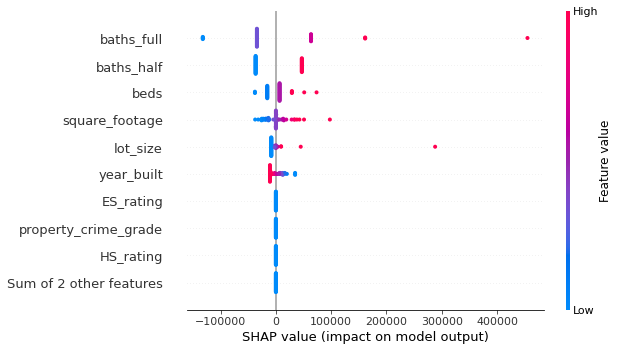

In [12]:
## a sample plot
shap.plots.beeswarm(shaps[5][1])

In [13]:
## OLD

# filename = 'linear_models.sav'
# pickle.dump(models, open(filename, 'wb'))

In [14]:
## series for each indexed by zipcode

mod_ser = pd.Series([], dtype='O')
for i in range(len(models)):
    mod_ser[models[i][1]] = models[i][0]
mod_ser = mod_ser.to_frame().reset_index()
mod_ser.columns = ['zipcode','model']
    
sv_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    sv_ser[shaps[i][2]] = shaps[i][1]
sv_ser = sv_ser.to_frame().reset_index()
sv_ser.columns = ['zipcode', 'shap_values']

exp_ser = pd.Series([], dtype = 'O')
for i in range(len(shaps)):
    exp_ser[shaps[i][2]] = shaps[i][0]
exp_ser = exp_ser.to_frame().reset_index()
exp_ser.columns = ['zipcode','explainer']

In [15]:
MS_df = mod_ser.merge(sv_ser, on='zipcode')
MS_df = MS_df.merge(exp_ser, on='zipcode')
MS_df.index = MS_df.zipcode

## The below can be taken out if desired.
MS_df = MS_df.drop(['zipcode'], axis=1)

In [16]:
## Can't print MS_df['shap_values'], but the column is there.

In [17]:
filename = 'MLR_modNshap.P'
pickle.dump(models, open(filename, 'wb'))